In [ ]:
import os
os.chdir('drive/My Drive/MLProject_20202')

In [ ]:
from keras import models
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from tqdm import tqdm
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, f1_score, classification_report

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
df = pd.read_json("Data/data_text_embedded.json")
df.head()

,embedded_text,embedded_title
0,"[1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...","[1, 141, 99, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[1, 205, 206, 207, 208, 209, 210, 211, 212, 21...","[1, 268, 213, 210, 211, 212, 2, 0, 0, 0, 0, 0,..."
2,"[1, 4, 442, 3, 443, 213, 248, 444, 445, 446, 2...","[1, 312, 490, 491, 9047, 2, 0, 0, 0, 0, 0, 0, ..."
3,"[1, 4, 572, 573, 267, 574, 219, 575, 576, 318,...","[1, 272, 103, 573, 572, 2, 0, 0, 0, 0, 0, 0, 0..."
4,"[1, 4, 796, 797, 798, 799, 800, 445, 801, 241,...","[1, 935, 871, 287, 2, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
df_cat = pd.read_csv('Data/data_all_categorical.csv', encoding='utf-8')

y = df_cat.fraudulent

df_cat_no_target = df_cat.loc[:, df_cat.columns != 'fraudulent']

categorical_vectors = df_cat_no_target.to_numpy()

In [27]:
MODEL_TYPE = 'lstm'
MODEL_INPUT = 256
MODEL_OUTPUT = 8

In [28]:
lstm_model = models.load_model(f'Model/LSTM/model_{MODEL_TYPE}_{MODEL_INPUT}_{MODEL_OUTPUT}.h5')

In [29]:
def get_context_vectors(lstm_model):
    # 256 is output size of the layer
    context_vectors = np.empty((0, MODEL_INPUT))
    # start sequence is 1 with all zeros behind
    start_sequence = np.zeros((1, MODEL_OUTPUT))
    start_sequence[0][0] = 1
    feature_extractor = models.Model(inputs = lstm_model.inputs, outputs = lstm_model.get_layer(index=8).output)
    for i in df.index:
        vector_to_context = np.reshape(np.array(df.embedded_text[i]), (-1, len(df.embedded_text[0])))
        features = feature_extractor([vector_to_context, start_sequence])
        context_vectors = np.append(context_vectors, np.array(features), axis=0)
    return context_vectors

In [30]:
context_vectors = get_context_vectors(lstm_model)

In [31]:
X = np.concatenate((context_vectors ,categorical_vectors), axis = 1)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [33]:
def cross_validation(estimator):
    _, train_scores, test_scores = learning_curve(estimator, X_train, y_train, cv=10, n_jobs=-1, train_sizes=[1.0, ], scoring="accuracy")
    test_scores = test_scores[0]
    mean, std = test_scores.mean(), test_scores.std()
    return mean, std

def plot(title, xlabel, X, Y, error, ylabel = "Accuracy"):
    plt.xlabel(xlabel)
    plt.title(title)
    plt.grid()
    plt.ylabel(ylabel)
    
    plt.errorbar(X, Y, error, linestyle='None', marker='o')

100%|██████████| 4/4 [30:19<00:00, 454.85s/it]


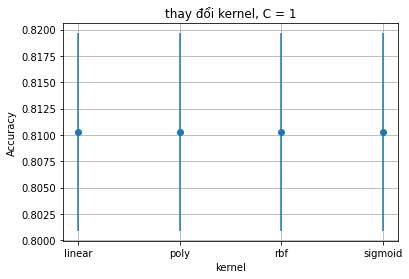

In [34]:
title = "thay đổi kernel, C = 1"
xlabel = "kernel"
X_axis = []
Y_axis = []
error = []
mean_max = 0
error_min = 1.0
svm_kernel = ""

for kernel in tqdm(['linear', 'poly', 'rbf', 'sigmoid']):
    # Với mỗi kernel được chọn, 
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = SVC(kernel=kernel, C=1.0, class_weight='balanced')
    mean, std = cross_validation(text_clf)
    X_axis.append(kernel)
    Y_axis.append(mean)
    error.append(std)
    if (mean_max <= mean) and (error_min >= std):
        mean_max = mean
        error_min = std
        svm_kernel = kernel

# lưu kết quả ra file ảnh 
plot(title, xlabel, X_axis, Y_axis, error)
plt.savefig(f'Image/LSTM/svm_change_kernel_{MODEL_TYPE}_{MODEL_INPUT}_{MODEL_OUTPUT}.png', bbox_inches='tight')
plt.show()

100%|██████████| 5/5 [56:03<00:00, 672.62s/it]


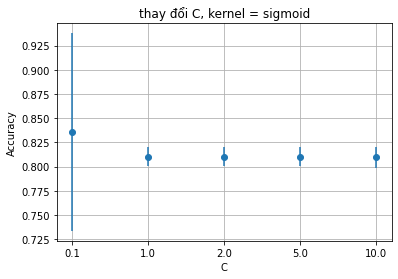

In [35]:
title = "thay đổi C, kernel = " + str(svm_kernel)
xlabel = "C"
X_axis = []
Y_axis = []
error = []
mean_max = 0.0
error_min = 1.0
svm_C = 0.0

for C in tqdm([.1, 1.0, 2.0, 5.0, 10.0]):
    # Với từng giá trị C nhận được, 
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = SVC(kernel=svm_kernel, C=C, class_weight='balanced')
    mean, std = cross_validation(text_clf)
    X_axis.append(str(C))
    Y_axis.append(mean)
    error.append(std)
    if (mean_max <= mean) and (error_min >= std):
        mean_max = mean
        error_min = std
        svm_C = C

# lưu kết quả ra file ảnh
plot(title, xlabel, X_axis, Y_axis, error)
plt.savefig(f'Image/LSTM/svm_change_C_{MODEL_TYPE}_{MODEL_INPUT}_{MODEL_OUTPUT}.png', bbox_inches='tight')
plt.show()

100%|██████████| 2/2 [00:13<00:00,  6.69s/it]


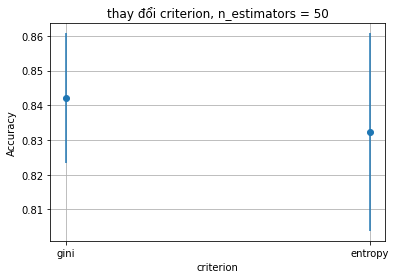

In [36]:
title = "thay đổi criterion, n_estimators = 50"
xlabel = "criterion"
X_axis = []
Y_axis = []
error = []
mean_max = 0.0
error_min = 1.0
rf_criterion = ""

for criterion in tqdm(["gini", "entropy"]):
    # Với mỗi criterion nhận được,
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = RandomForestClassifier(criterion=criterion, n_estimators=50, class_weight='balanced')
    mean, std = cross_validation(text_clf)
    X_axis.append(str(criterion))
    Y_axis.append(mean)
    error.append(std)
    if (mean_max <= mean) and (error_min >= std):
        mean_max = mean
        error_min = std
        rf_criterion = criterion

# lưu kết quả ra file ảnh
plot(title, xlabel, X_axis, Y_axis, error)
plt.savefig(f'Image/LSTM/RF_change_criterion_{MODEL_TYPE}_{MODEL_INPUT}_{MODEL_OUTPUT}.png', bbox_inches='tight')
plt.show()

100%|██████████| 4/4 [00:58<00:00, 14.58s/it]


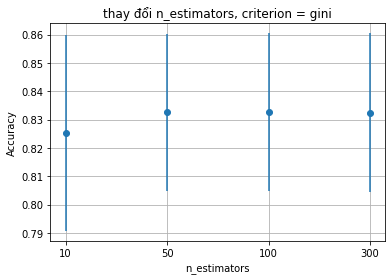

In [37]:
title = "thay đổi n_estimators, criterion = " + str(rf_criterion)
xlabel = "n_estimators"
X_axis = []
Y_axis = []
error = []
mean_max = 0.0
error_min = 1.0
rf_estimators = 0.0

for n_estimators in tqdm([10, 50, 100, 300]):
    # Với từng giá trị n_estimators nhận được,
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = RandomForestClassifier(criterion=rf_criterion, n_estimators=n_estimators, class_weight='balanced')
    mean, std = cross_validation(text_clf)
    X_axis.append(str(n_estimators))
    Y_axis.append(mean)
    error.append(std)
    if (mean_max <= mean) and (error_min >= std):
        mean_max = mean
        error_min = std
        rf_estimators = n_estimators

# lưu kết quả ra file ảnh
plot(title, xlabel, X_axis, Y_axis, error)
plt.savefig(f'Image/LSTM/RF_change_N_{MODEL_TYPE}_{MODEL_INPUT}_{MODEL_OUTPUT}.png', bbox_inches='tight')
plt.show()

100%|██████████| 5/5 [03:34<00:00, 42.82s/it]


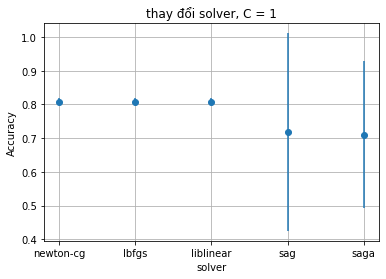

In [38]:
title = "thay đổi solver, C = 1"
xlabel = "solver"
X_axis = []
Y_axis = []
error = []
mean_max = 0.0
error_min = 1.0
lr_solver = ""

for solver in tqdm(["newton-cg", "lbfgs", "liblinear", "sag", "saga"]):
    # Với mỗi criterion nhận được,
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = LogisticRegression(solver=solver, C=1, class_weight='balanced', max_iter=400)
    mean, std = cross_validation(text_clf)
    X_axis.append(str(solver))
    Y_axis.append(mean)
    error.append(std)
    if (mean_max <= mean) and (error_min >= std):
        mean_max = mean
        error_min = std
        lr_solver = solver

# lưu kết quả ra file ảnh
plot(title, xlabel, X_axis, Y_axis, error)
plt.savefig(f'Image/LSTM/Logistic_change_solver_{MODEL_TYPE}_{MODEL_INPUT}_{MODEL_OUTPUT}.png', bbox_inches='tight')
plt.show()

100%|██████████| 5/5 [00:23<00:00,  4.61s/it]


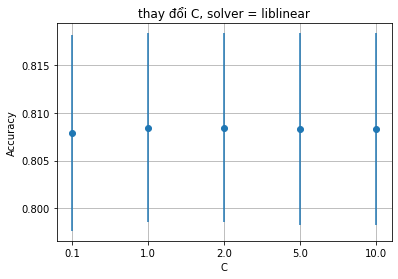

In [39]:
title = "thay đổi C, solver = " + str(lr_solver)
xlabel = "C"
X_axis = []
Y_axis = []
error = []
mean_max = 0.0
error_min = 1.0
lr_C = 0.0


for C in tqdm([.1, 1.0, 2.0, 5.0, 10.0]):
    # Với từng giá trị C nhận được, 
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = LogisticRegression(solver=lr_solver, C=C, class_weight='balanced', max_iter=400)
    mean, std = cross_validation(text_clf)
    X_axis.append(str(C))
    Y_axis.append(mean)
    error.append(std)
    if (mean_max <= mean) and (error_min >= std):
        mean_max = mean
        error_min = std
        lr_C = C

# lưu kết quả ra file ảnh
plot(title, xlabel, X_axis, Y_axis, error)
plt.savefig(f'Image/LSTM/Logistic_change_C_{MODEL_TYPE}_{MODEL_INPUT}_{MODEL_OUTPUT}.png', bbox_inches='tight')
plt.show()

In [40]:
svm_ = SVC(kernel=svm_kernel, C=svm_C, class_weight='balanced')
rf = RandomForestClassifier(criterion=rf_criterion, n_estimators=rf_estimators, class_weight='balanced')
logistic = LogisticRegression(solver=lr_solver, C=lr_C, class_weight='balanced', max_iter=400)

# Huấn luyện các mô hình trên tập dữ liệu train đầy đủ
svm_.fit(X_train, y_train)
rf.fit(X_train, y_train)
logistic.fit(X_train, y_train)

LogisticRegression(C=2.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=400, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
import xgboost as xgb

In [42]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [43]:
# number of negative/positive class in dataser
neg = sum(y==0)
pos = sum(y==1)
print(f'{neg} {pos}')

17014 866


In [44]:
param_init = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "max_depth": 4, # default: 3 only for depthwise
    "n_estimators": 1000, # default: 500
    "learning_rate": 0.025, # default: 0.05
    "subsample": 0.7,
    "colsample_bytree": 0.6,  # default:  1.0
    "colsample_bylevel": 0.5, # default: 1.0
    "random_state": 0,
    "scale_pos_weight": neg/pos,
 
    #
    "silent": True,
    "n_jobs": 16, 
 
    #
    "tree_method": "hist", # default: auto
    "grow_policy": "lossguide", # default depthwise
}
 
param_fit = {
    "eval_metric": ["rmse", "logloss", "auc", "aucpr"],
    "early_stopping_rounds": 500, # default: 100
    "verbose": 200,
    "eval_set": [(X_train, y_train), (X_val, y_val), (X_test, y_test)]
}
 
xgb_model = xgb.XGBClassifier(**param_init)
xgb_model.fit(X_train, y_train, **param_fit)
evals_result = xgb_model.evals_result()

[0]	validation_0-rmse:0.49673	validation_0-logloss:0.686633	validation_0-auc:0.78225	validation_0-aucpr:0.171882	validation_1-rmse:0.496773	validation_1-logloss:0.686713	validation_1-auc:0.789335	validation_1-aucpr:0.164612	validation_2-rmse:0.496677	validation_2-logloss:0.686523	validation_2-auc:0.790496	validation_2-aucpr:0.194803
Multiple eval metrics have been passed: 'validation_2-aucpr' will be used for early stopping.

Will train until validation_2-aucpr hasn't improved in 500 rounds.
[200]	validation_0-rmse:0.398725	validation_0-logloss:0.498811	validation_0-auc:0.837424	validation_0-aucpr:0.304749	validation_1-rmse:0.402414	validation_1-logloss:0.506935	validation_1-auc:0.823069	validation_1-aucpr:0.245668	validation_2-rmse:0.395386	validation_2-logloss:0.493931	validation_2-auc:0.863757	validation_2-aucpr:0.334008
[400]	validation_0-rmse:0.395926	validation_0-logloss:0.489428	validation_0-auc:0.844903	validation_0-aucpr:0.310822	validation_1-rmse:0.399474	validation_1-logloss

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

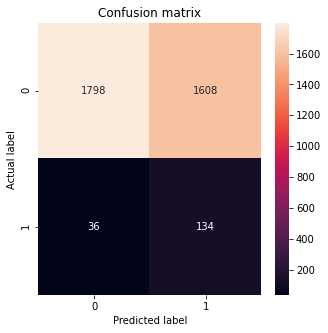

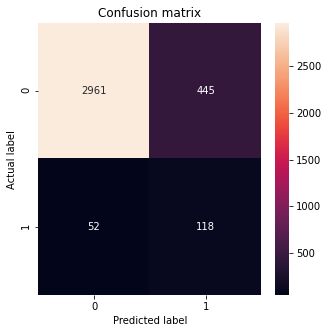

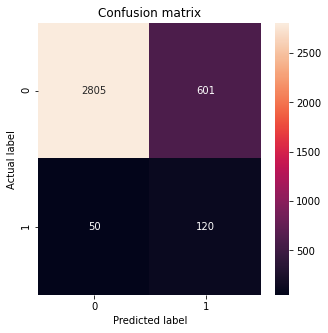

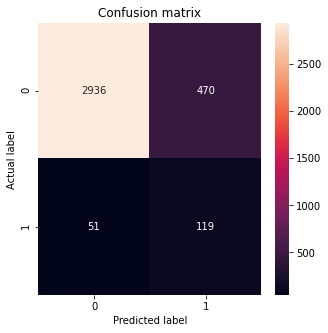

In [46]:
for clf, clf_dict in zip([svm_, rf, logistic, xgb_model], ['svm', 'rf', 'logistic', 'xgboost']):
    cm = confusion_matrix(y_test, clf.predict(X_test) > 0.5)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.savefig(f'Result/LSTM/CM/{clf_dict}_{MODEL_TYPE}_cm.png')
    plt.show()

In [47]:
import pickle

In [48]:
# store models
for clf, clf_dict in zip([svm_, rf, logistic, xgb_model], ['svm', 'rf', 'logistic', 'xgboost']):
    with open(f'Model/LSTM/Classification/{MODEL_TYPE}_{clf_dict}.pkl', 'wb') as file:
        pickle.dump(clf, file)